In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

C:\Users\86183\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('../data/PJME_hourly.csv')

df = df.set_index('Datetime')

df.index = pd.to_datetime(df.index)

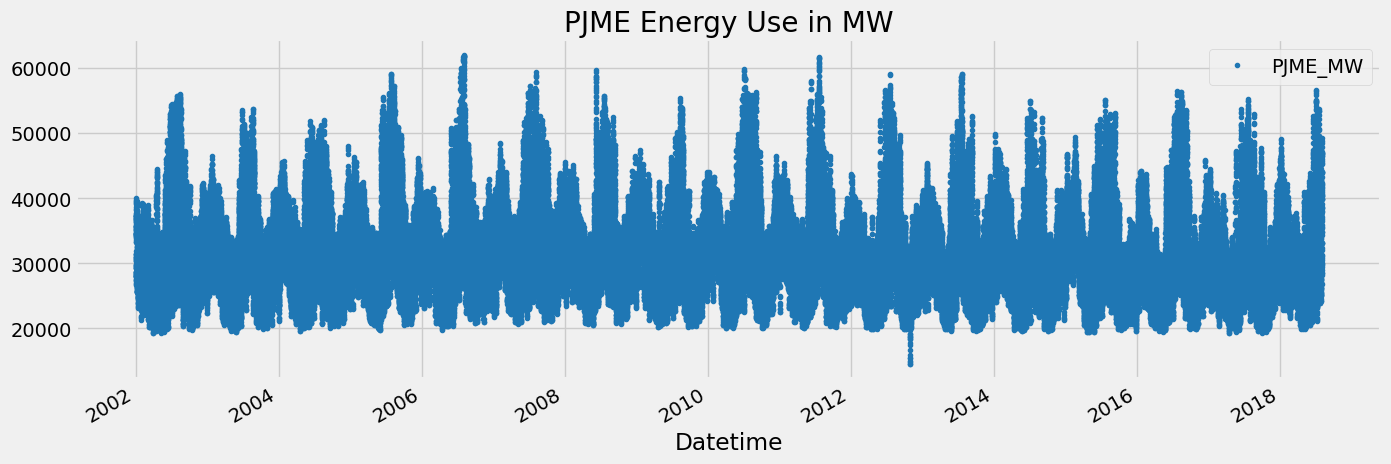

In [3]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')

plt.show()

<AxesSubplot:ylabel='Frequency'>

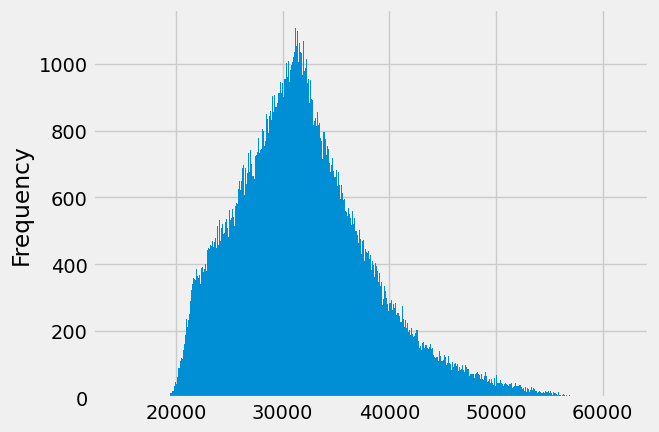

In [4]:
df['PJME_MW'].plot(kind='hist', bins=500)

<AxesSubplot:title={'center':'Outliers'}, xlabel='Datetime'>

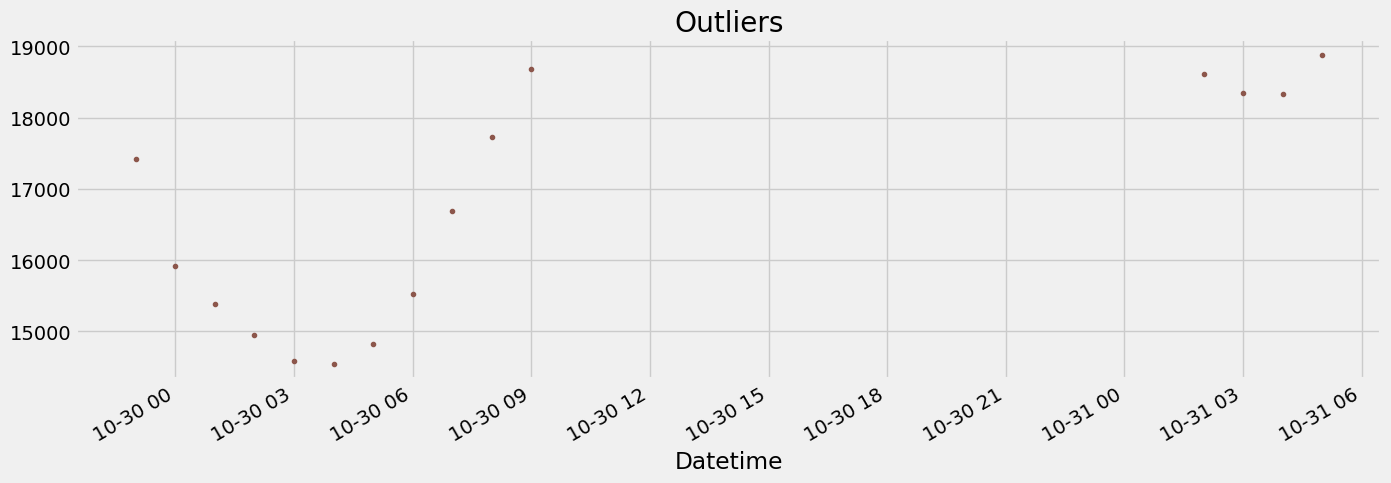

In [5]:
df.query('PJME_MW < 19_000')['PJME_MW'].plot(style='.',
                                             figsize=(15, 5),
                                             color=color_pal[5],
                                             title='Outliers')

In [6]:
df = df.query('PJME_MW > 19_000').copy()

In [7]:
train = df.loc[df.index < '01-01-2015']

test = df.loc[df.index >= '01-01-2015']

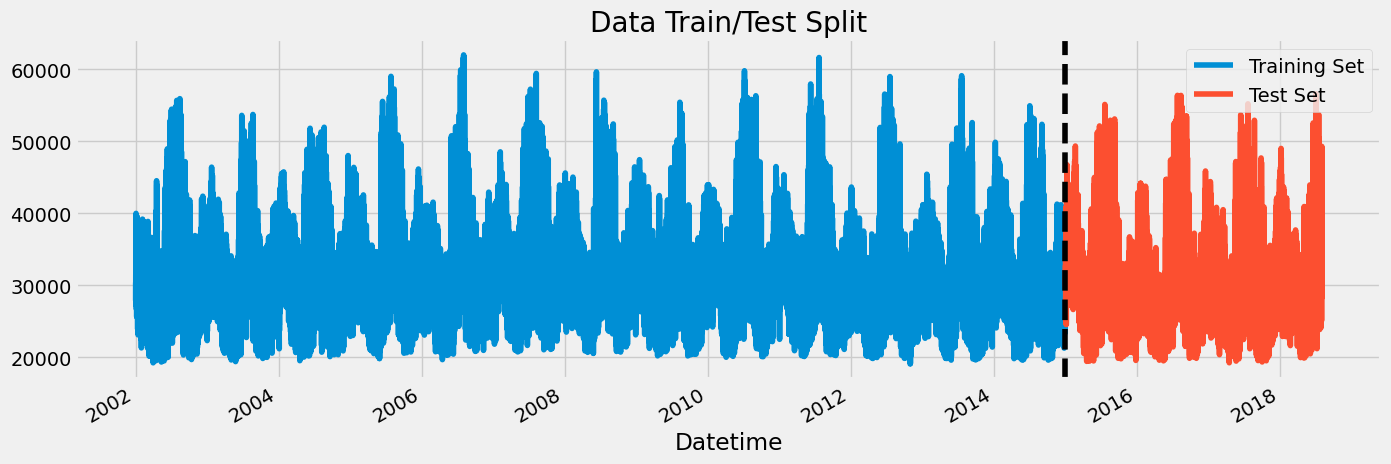

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))

train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')

ax.axvline('01-01-2015', color='black', ls='--')

ax.legend(['Training Set', 'Test Set'])

plt.show()

## Time Series Cross Validation

In [9]:
from sklearn.model_selection import TimeSeriesSplit

In [10]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

df = df.sort_index()

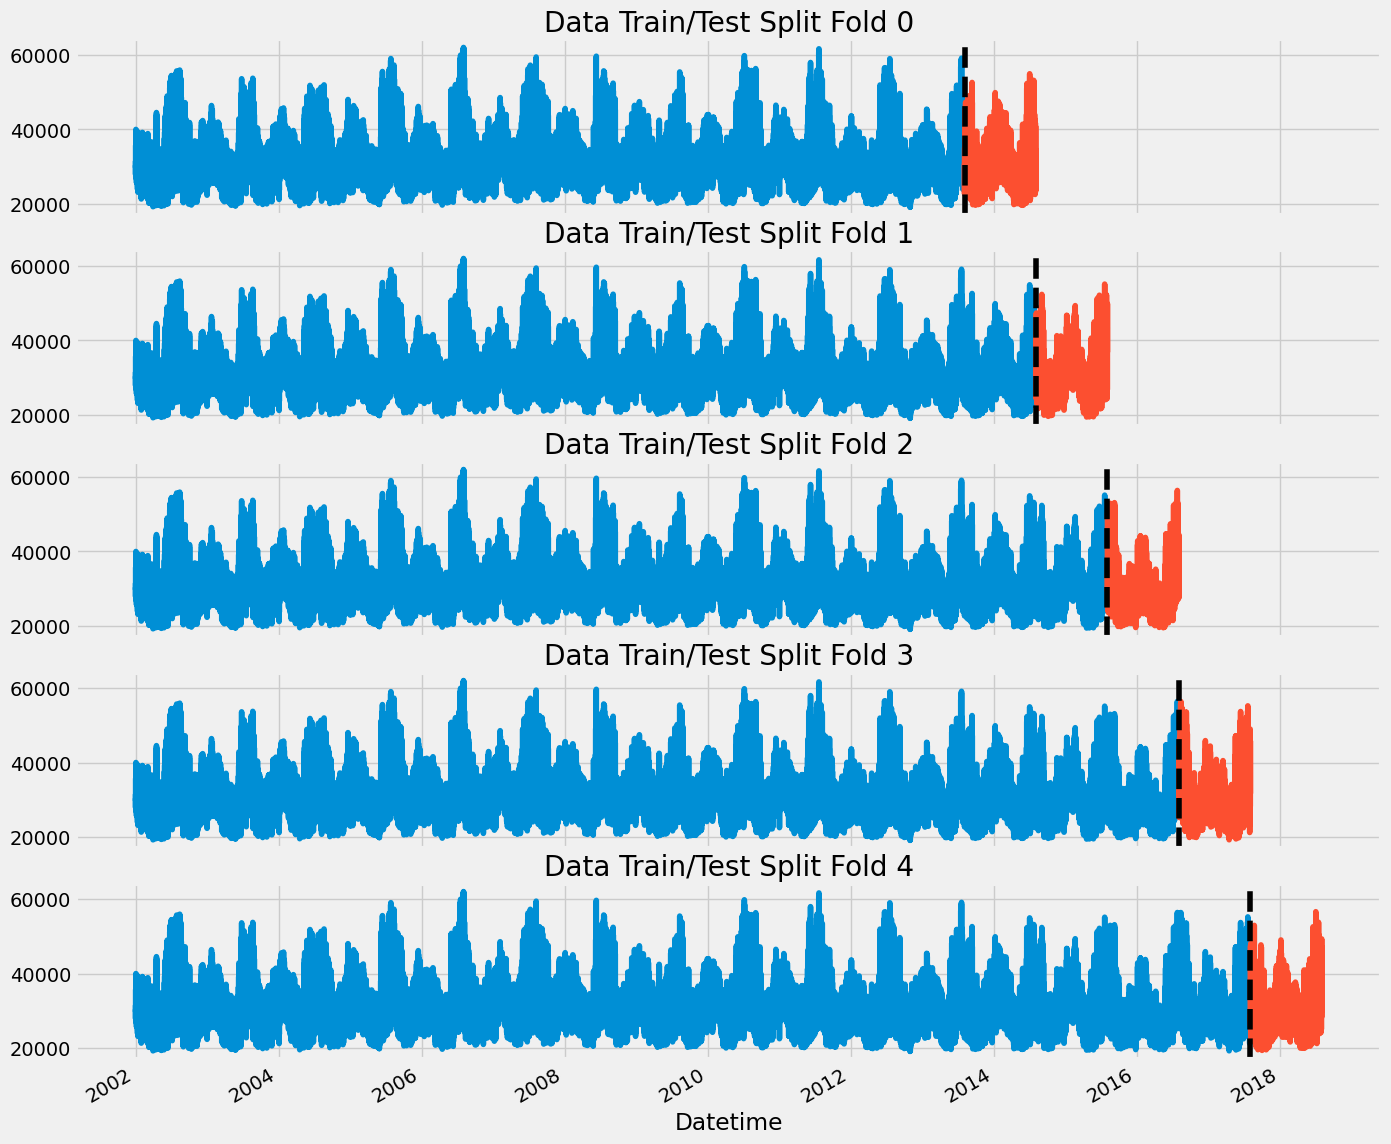

In [11]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')

    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')

    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.show()

In [12]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [13]:
df = create_features(df)

## Lag Features

In [14]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [15]:
df = add_lags(df)

## Training

In [16]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

df = df.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, 
                           booster='gbtree',
                           n_estimators=1000,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.50391	validation_1-rmse:31956.66211


C:\Users\86183\anaconda3\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[100]	validation_0-rmse:12532.16113	validation_1-rmse:11907.12305
[200]	validation_0-rmse:5744.94824	validation_1-rmse:5353.51611
[300]	validation_0-rmse:3868.56445	validation_1-rmse:3898.53882
[400]	validation_0-rmse:3430.63159	validation_1-rmse:3758.24536
[500]	validation_0-rmse:3313.81201	validation_1-rmse:3774.01269
[600]	validation_0-rmse:3257.80493	validation_1-rmse:3786.43481
[700]	validation_0-rmse:3216.66821	validation_1-rmse:3794.42798
[800]	validation_0-rmse:3181.24585	validation_1-rmse:3803.77295
[900]	validation_0-rmse:3149.59009	validation_1-rmse:3796.79565
[999]	validation_0-rmse:3120.67651	validation_1-rmse:3788.34692
[0]	validation_0-rmse:32672.17188	validation_1-rmse:32138.88672


C:\Users\86183\anaconda3\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[100]	validation_0-rmse:12513.57129	validation_1-rmse:12221.41602
[200]	validation_0-rmse:5755.56201	validation_1-rmse:5655.33252
[300]	validation_0-rmse:3904.98462	validation_1-rmse:3931.66016
[400]	validation_0-rmse:3476.76807	validation_1-rmse:3598.75342
[500]	validation_0-rmse:3355.49390	validation_1-rmse:3530.19653
[600]	validation_0-rmse:3298.89526	validation_1-rmse:3492.70068
[700]	validation_0-rmse:3258.68774	validation_1-rmse:3468.00342
[800]	validation_0-rmse:3224.41724	validation_1-rmse:3446.84082
[900]	validation_0-rmse:3196.67993	validation_1-rmse:3434.48120
[999]	validation_0-rmse:3171.77954	validation_1-rmse:3422.73071
[0]	validation_0-rmse:32631.19922	validation_1-rmse:31073.24414


C:\Users\86183\anaconda3\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[100]	validation_0-rmse:12498.55762	validation_1-rmse:11133.99707
[200]	validation_0-rmse:5748.86426	validation_1-rmse:4812.20947
[300]	validation_0-rmse:3913.77393	validation_1-rmse:3546.83594
[400]	validation_0-rmse:3491.37817	validation_1-rmse:3490.31299
[500]	validation_0-rmse:3376.11621	validation_1-rmse:3547.43872
[600]	validation_0-rmse:3318.25806	validation_1-rmse:3598.29492
[700]	validation_0-rmse:3276.29736	validation_1-rmse:3624.87500
[800]	validation_0-rmse:3244.79150	validation_1-rmse:3655.43066
[900]	validation_0-rmse:3217.69458	validation_1-rmse:3683.82446
[999]	validation_0-rmse:3190.68115	validation_1-rmse:3712.56567
[0]	validation_0-rmse:32528.44141	validation_1-rmse:31475.37891


C:\Users\86183\anaconda3\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[100]	validation_0-rmse:12461.94434	validation_1-rmse:12016.85352
[200]	validation_0-rmse:5736.10303	validation_1-rmse:5797.82275
[300]	validation_0-rmse:3912.41577	validation_1-rmse:4386.88721
[400]	validation_0-rmse:3495.18945	validation_1-rmse:4173.48291
[500]	validation_0-rmse:3380.56592	validation_1-rmse:4117.65576
[600]	validation_0-rmse:3320.94653	validation_1-rmse:4108.32373
[700]	validation_0-rmse:3280.72192	validation_1-rmse:4092.06543
[800]	validation_0-rmse:3249.58032	validation_1-rmse:4095.15845
[900]	validation_0-rmse:3220.31641	validation_1-rmse:4090.95972
[999]	validation_0-rmse:3196.36694	validation_1-rmse:4065.66211
[0]	validation_0-rmse:32462.07812	validation_1-rmse:31463.86914


C:\Users\86183\anaconda3\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[100]	validation_0-rmse:12445.22852	validation_1-rmse:11954.79297
[200]	validation_0-rmse:5750.43506	validation_1-rmse:5610.39502
[300]	validation_0-rmse:3950.31982	validation_1-rmse:4149.66309
[400]	validation_0-rmse:3539.13794	validation_1-rmse:4001.28784
[500]	validation_0-rmse:3428.48950	validation_1-rmse:4028.80005
[600]	validation_0-rmse:3372.04883	validation_1-rmse:4052.09375
[700]	validation_0-rmse:3334.09888	validation_1-rmse:4052.86548
[800]	validation_0-rmse:3304.12354	validation_1-rmse:4044.70801
[900]	validation_0-rmse:3277.37231	validation_1-rmse:4037.74438
[999]	validation_0-rmse:3251.40991	validation_1-rmse:4024.17676


In [17]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3802.6965
Fold scores:[3788.3472265677688, 3422.7313522991994, 3712.565337136328, 4065.6619422063677, 4024.1768497078638]


## Predict

In [18]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=1000,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

[0]	validation_0-rmse:32403.89844


C:\Users\86183\anaconda3\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[100]	validation_0-rmse:12426.43164
[200]	validation_0-rmse:5752.10742
[300]	validation_0-rmse:3971.35938
[400]	validation_0-rmse:3571.35425
[500]	validation_0-rmse:3455.44727
[600]	validation_0-rmse:3402.08813
[700]	validation_0-rmse:3365.96558
[800]	validation_0-rmse:3336.94629
[900]	validation_0-rmse:3311.71655
[999]	validation_0-rmse:3287.68726


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [19]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [20]:
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')

future_df = pd.DataFrame(index=future)

future_df['isFuture'] = True

df['isFuture'] = False

df_and_future = pd.concat([df, future_df])

df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [21]:
future_w_features = df_and_future.query('isFuture').copy()

In [22]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

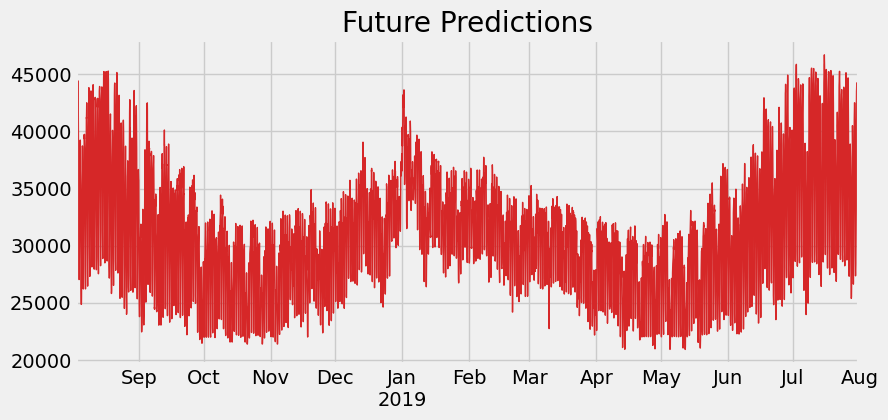

In [23]:
future_w_features['pred'].plot(figsize=(9, 4),
                               color=color_pal[3],
                               ms=1,
                               lw=1,
                               title='Future Predictions')

plt.show()

## Save Model

In [24]:
reg.save_model('model.json')

<AxesSubplot:title={'center':'Future Predictions'}>

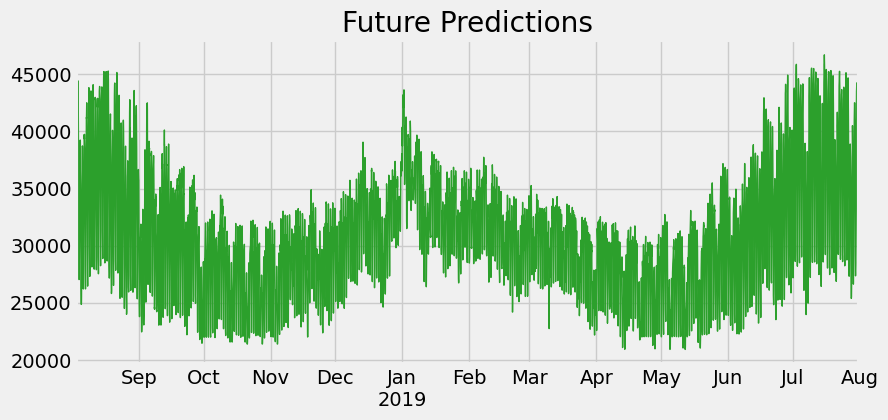

In [25]:
reg_new = xgb.XGBRegressor()

reg_new.load_model('model.json')

future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])

future_w_features['pred'].plot(figsize=(9, 4),
                               color=color_pal[2],
                               ms=1,
                               lw=1,
                               title='Future Predictions')